## Notebook to research diabetes onset 

In [1]:
%load_ext autoreload
%autoreload 2
#%load_ext Cython
#%reload_ext Cython

import warnings

def warn():
    pass

warnings.warn = warn

In [2]:
import pandas as pd
import numpy as np
import time
import datetime as dt
from pathlib import Path

#custom
from data_functions import make_date_to_MYR
from diabetes_onset import process_canary, get_tc, in_canary, diabet_onset, match_data, not_first_month_diabetes


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

### Load Pmpm Canary data

In [3]:
%%time
canary_p = '../../temp/CANARY.p'
pmpm_p = '../../temp/PMPM.p'

canary = pd.read_pickle(canary_p)
pmpm = pd.read_pickle(pmpm_p)

#drop pmpm duplicates
pmpm.drop_duplicates(subset = ['PERS_ID', 'MYR'], inplace = True)
canary.drop_duplicates(subset = ['PERS_ID'], inplace = True)

CPU times: user 5.59 s, sys: 5.54 s, total: 11.1 s
Wall time: 11.1 s


### Process Canary, 
1. Drop register dates beyond pmpm max date
2. Transform register date to MYR
3. Keep only ids and MYR

### Get Controls and Treated

In [4]:
%%time
canary2 = process_canary(canary, pmpm.MYR.max())
treated, controls = get_tc(pmpm.copy(), canary2)

CPU times: user 3.71 s, sys: 3.27 s, total: 6.99 s
Wall time: 6.98 s


### Get a matched set from controls

In [5]:
%%time
month_to_match = 201701

nocols = ['PERS_ID', 'MYR', 'CC_DIABETES']
common_causes_names = np.setdiff1d(treated.columns, nocols)
neighbors = 50
matched, matched_ids, data, indx = match_data(treated.copy(), controls.copy(),
                     month = month_to_match,
                     ccn = common_causes_names,
                     nn = neighbors)

/usr/local/lib64/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


CPU times: user 4.01 s, sys: 2.41 s, total: 6.43 s
Wall time: 4.8 s


### Get the data for controls and treated to study diabetes onset

In [6]:
controlsf = controls[controls.PERS_ID.isin(matched_ids)].reset_index(drop = True)[['PERS_ID', 'MYR', 'CC_DIABETES']]
treatedf = treated[['PERS_ID', 'MYR', 'CC_DIABETES']]
pmpmf = pmpm[['PERS_ID', 'MYR', 'CC_DIABETES']]


### Get only ids that they appear in their first month with flag 0 in CC Diabetes

%%time
iddc = not_first_month_diabetes(controlsf.copy())
iddtr = not_first_month_diabetes(treatedf.copy())
iddpmpm = not_first_month_diabetes(pmpmf.copy())

final_control_ids = iddc[iddc.First_Month == True].PERS_ID
final_treated_ids = iddtr[iddtr.First_Month == True].PERS_ID
final_pmpm_ids = iddpmpm[iddpmpm.First_Month == True].PERS_ID


controlsff = controlsf[controlsf.PERS_ID.isin(final_control_ids)]
treatedff = treatedf[treatedf.PERS_ID.isin(final_treated_ids)]
pmpmff = pmpmf[pmpmf.PERS_ID.isin(final_pmpm_ids)]

In [ ]:
%%time
controlsff = filter_first_month_diabetes(controlsf)
treatedff = filter_first_month_diabetes(treatedf)
pmpmff = filter_first_month_diabetes(pmpmf)

### Run the Diabetes onset Function

In [9]:
%%time
con_onset = diabet_onset(controlsff.copy(), 'Diabetes_Con')
treated_onset = diabet_onset(treatedff.copy(), 'Diabetes_Tr')
pmpm_onset = diabet_onset(pmpmff.copy(), 'Diabetes_PM')

CPU times: user 1min 27s, sys: 617 ms, total: 1min 27s
Wall time: 1min 27s


In [ ]:
treated_cc = in_canary(treatedf.copy(), canary2.copy())
treated_c = filter_first_month_diabetes(treated_cc)
treated_c_onset =  diabet_onset(treated_c.copy(), 'Tr2')

%%time
treated_c = in_canary(treatedf.copy(), canary2.copy())
treated_c_onset =  diabet_onset(treated_c.copy(), 'Tr2')

In [11]:
joint = pd.concat((con_onset, treated_onset, pmpm_onset, treated_c_onset), axis = 1)

In [12]:
joint

Sample  Diabetes_Con  Per_1000  Sample  Diabetes_Tr  Per_1000    Sample  Diabetes_PM  Per_1000  Sample  Tr2   Per_1000
MYR                                                                                                                            
201701      NaN           NaN       NaN     NaN          NaN       NaN       NaN          NaN       NaN     NaN  NaN        NaN
201702  26723.0          55.0  2.058152   727.0          0.0  0.000000  122405.0        250.0  2.042400     NaN  NaN        NaN
201703  25496.0          56.0  2.196423   732.0          1.0  1.366120  122264.0        304.0  2.486423     NaN  NaN        NaN
201704  24560.0          48.0  1.954397   735.0          2.0  2.721088  123340.0        269.0  2.180963     NaN  NaN        NaN
201705  23773.0          59.0  2.481807   749.0          0.0  0.000000  123939.0        291.0  2.347929     NaN  NaN        NaN
201706  23122.0          35.0  1.513710   758.0          0.0  0.000000  125212.0        279.0  2.228221     NaN  NaN        NaN
201707  22339.0          39.0  1.745826   767.0          1.0  1.303781  125643.0        254.0  2.021601     NaN  NaN        NaN
201708  21678.0          35.0  1.614540   782.0          0.0  0.000000  125497.0        253.0  2.015984     NaN  NaN        NaN
201709  21092.0          39.0  1.849042   788.0          0.0  0.000000  125687.0        235.0  1.869724     NaN  NaN        NaN
201710  20486.0          28.0  1.366787   791.0          1.0  1.264223  125777.0        222.0  1.765029     NaN  NaN        NaN
201711  20031.0          34.0  1.697369   800.0          0.0  0.000000  126879.0        237.0  1.867921     1.0  0.0   0.000000
201712  19629.0          43.0  2.190636   805.0          0.0  0.000000  127476.0        230.0  1.804261     2.0  0.0   0.000000
201801  18946.0          39.0  2.058482   817.0          0.0  0.000000  125765.0        235.0  1.868564     2.0  0.0   0.000000
201802  18914.0          27.0  1.427514   848.0          0.0  0.000000  129313.0        263.0  2.033825     2.0  0.0   0.000000
201803  18829.0          24.0  1.274630   860.0          0.0  0.000000  130204.0        245.0  1.881663     8.0  0.0   0.000000
201804  18772.0          29.0  1.544854   879.0          0.0  0.000000  132019.0        280.0  2.120907    18.0  0.0   0.000000
201805  18727.0          19.0  1.014578   896.0          0.0  0.000000  133330.0        249.0  1.867547    23.0  0.0   0.000000
201806  18764.0          29.0  1.545513   915.0          0.0  0.000000  134809.0        266.0  1.973162    30.0  0.0   0.000000
201807  18719.0          24.0  1.282120   928.0          0.0  0.000000  136026.0        200.0  1.470307    43.0  0.0   0.000000
201808  18686.0          36.0  1.926576   930.0          1.0  1.075269  136658.0        258.0  1.887925    51.0  0.0   0.000000
201809  18621.0          27.0  1.449976   942.0          1.0  1.061571  137925.0        228.0  1.653072    55.0  0.0   0.000000
201810  18549.0          30.0  1.617338   966.0          2.0  2.070393  138673.0        252.0  1.817225    60.0  0.0   0.000000
201811  18492.0          20.0  1.081549   978.0          2.0  2.044990  140070.0        235.0  1.677733    70.0  1.0  14.285714
201812  18419.0          20.0  1.085835   983.0          0.0  0.000000  141339.0        185.0  1.308910    97.0  0.0   0.000000
201901  17609.0          30.0  1.703674   994.0          0.0  0.000000  135645.0        280.0  2.064212   119.0  0.0   0.000000
201902  17720.0          33.0  1.862302  1063.0          0.0  0.000000  141286.0        292.0  2.066730   177.0  0.0   0.000000
201903  17635.0          28.0  1.587752  1093.0          0.0  0.000000  142188.0        331.0  2.327904   209.0  0.0   0.000000
201904  17666.0          27.0  1.528360  1126.0          3.0  2.664298  144075.0        358.0  2.484817   236.0  0.0   0.000000
201905  17673.0          39.0  2.206756  1147.0          1.0  0.871840  145615.0        373.0  2.561549   263.0  1.0   3.802281
201906  17675.0          26.0  1.471004  

In [13]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-dark')

/home/gmavroud/.local/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [14]:
jointcon = joint.Per_1000.iloc[1:, 0].reset_index()
jointTr = joint.Per_1000.iloc[1:, 1].reset_index()
jointpmpm = joint.Per_1000.iloc[1:, 2].reset_index()
jointTr2 = joint.Per_1000.iloc[1:, 3].reset_index()


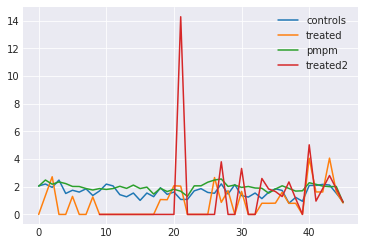

In [15]:
fig, ax = plt.subplots(1,1)
xx = np.arange(len(jointTr))
ax.plot(xx, jointcon.Per_1000, label = 'controls')
ax.plot(xx, jointTr.Per_1000, label = 'treated')
ax.plot(xx, jointpmpm.Per_1000, label = 'pmpm')
ax.plot(xx, jointTr2.Per_1000, label = 'treated2')
#ax.set_xlim(left = 33)
#ax.set_ylim(bottom = 0)
ax.grid()
#ax.set_xticks(jointTr.MYR.values)
#ax.set_xticklabels([str(date) for date in jointTr.MYR.values], rotation = 45)
plt.legend()
fig.show()

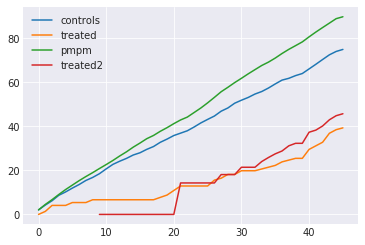

In [16]:
fig, ax = plt.subplots(1,1)
xx = np.arange(len(jointTr))
ax.plot(xx, jointcon.Per_1000.cumsum(), label = 'controls')
ax.plot(xx, jointTr.Per_1000.cumsum(), label = 'treated')
ax.plot(xx, jointpmpm.Per_1000.cumsum(), label = 'pmpm')
ax.plot(xx, jointTr2.Per_1000.cumsum() , label = 'treated2')
#ax.set_xlim(left = 33)
#ax.set_ylim(bottom = 0)
ax.grid()
#ax.set_xticks(jointTr.MYR.values)
#ax.set_xticklabels([str(date) for date in jointTr.MYR.values], rotation = 45)
plt.legend()
fig.show()

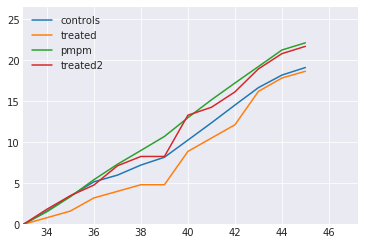

In [17]:
fig, ax = plt.subplots(1,1)
xx = np.arange(len(jointTr))
ax.plot(xx, jointcon.Per_1000.cumsum()-jointcon.Per_1000.cumsum().iloc[33], label = 'controls')
ax.plot(xx, jointTr.Per_1000.cumsum()-jointTr.Per_1000.cumsum().iloc[33], label = 'treated')
ax.plot(xx, jointpmpm.Per_1000.cumsum()-jointpmpm.Per_1000.cumsum().iloc[33], label = 'pmpm')
ax.plot(xx, jointTr2.Per_1000.cumsum() - jointTr2.Per_1000.cumsum().iloc[33], label = 'treated2')
ax.set_xlim(left = 33)
ax.set_ylim(bottom = 0)
ax.grid()
#ax.set_xticks(jointTr.MYR.values)
#ax.set_xticklabels([str(date) for date in jointTr.MYR.values], rotation = 45)
plt.legend()
fig.show()

In [18]:
from sklearn.linear_model import LinearRegression as LR

X1 = jointcon.Per_1000.cumsum().iloc[33:]
X2 = jointTr2.Per_1000.cumsum().iloc[33:]
X3 = jointpmpm.Per_1000.cumsum().iloc[33:]



In [19]:
model = LR()
model2 = LR()
model3 = LR()

model  = model.fit(np.arange(len(X1)).reshape(-1,1), X1.values.reshape(-1,1) )
model2 = model2.fit(np.arange(len(X2)).reshape(-1,1), X2.values.reshape(-1,1) )
model3 = model3.fit(np.arange(len(X3)).reshape(-1,1), X3.values.reshape(-1,1) )



In [20]:
model.coef_,  model2.coef_, model3.coef_

(array([[1.61706965]]), array([[1.86906928]]), array([[1.92193244]]))

In [21]:
joint.describe().loc[['mean', 'std']]

Sample  Diabetes_Con  Per_1000       Sample  Diabetes_Tr  Per_1000         Sample  Diabetes_PM  Per_1000      Sample       Tr2  Per_1000
mean  18902.956522     31.108696  1.628332  1017.891304     0.934783  0.854174  141550.543478   275.369565  1.950861  386.486486  0.648649  1.235260
std    2483.376357     10.148297  0.404849   192.945269     1.218417  1.062669   13456.572672    46.930852  0.301403  396.600948  1.059775  2.562219